## You may want to download it to run in your local computer.

## Clustering analysis

### 0. Load libraries

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import math
from scipy.stats import kurtosis, skew
import altair as alt
from mycolorpy import colorlist as mcp
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
from langdetect import detect

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
RANDOM_STATE= 42

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

import gower
import prince
import umap
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA, FactorAnalysis
from kneed import KneeLocator

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from pickle import dump, load

In [3]:
# !pip install --upgrade pip

# !pip install numba==0.53.1

# !pip install umap-learn==0.5.1

# !pip install gower

# !pip install scikit-learn-extra

# !pip install kmodes

# !pip install prince

# !pip install kneed

# !pip install mycolorpy

### 1. Load the data

In [4]:
# load the cleaned listing data
cleaned_listing_df = pd.read_pickle('../data/data_cleaned/cleaned_listing_and_review_with_polarity.zip')
print(cleaned_listing_df.shape)

(4933, 73)


### 2. Remove unnecessary columns

In [5]:
# remove some columns (duplicated, date columns and text data)

date_col = cleaned_listing_df.select_dtypes('datetime64[ns]').columns.to_list()

removed_col = ['host_id',
               'host_listings_count',
               'host_total_listings_count',
               'minimum_minimum_nights',
               'maximum_minimum_nights',
               'minimum_maximum_nights',
               'maximum_maximum_nights',
               'minimum_nights_avg_ntm',
               'maximum_nights_avg_ntm',
               'availability_30',
               'availability_60',
               'availability_90',
               'availability_365',
               'number_of_reviews_ltm',
               'number_of_reviews_l30d',
               'host_response_time_encoded'] + date_col + ['description',
                                                           'neighborhood_overview',
                                                           'picture_url',
                                                           'host_url',
                                                           'host_name',
                                                           'host_location',
                                                           'host_about',
                                                           'host_picture_url',
                                                           'host_neighbourhood',
                                                           'comments',
                                                           'host_verifications',
                                                           'amenities',
                                                           'listing_url',
                                                           'listing_name']

### 3. Explore the data

In [6]:
# dataframe after removing some unnecessary columns
listing_df = cleaned_listing_df.loc[:,~cleaned_listing_df.columns.isin(removed_col)]
print(listing_df.shape)

(4933, 39)


In [7]:
binary_cols = ['host_is_superhost',
               'host_has_profile_pic',
               'host_identity_verified',
               'has_availability',
               'instant_bookable','has_license']

listing_df[binary_cols] = listing_df[binary_cols].replace([1,0],['True','False'])

In [8]:
# categorical columns in the dataframe
cat_col = listing_df.select_dtypes('object').columns
cat_col

Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'property_type', 'room_type',
       'has_availability', 'has_license', 'instant_bookable'],
      dtype='object')

### 3.1 Distribution of each categorical column

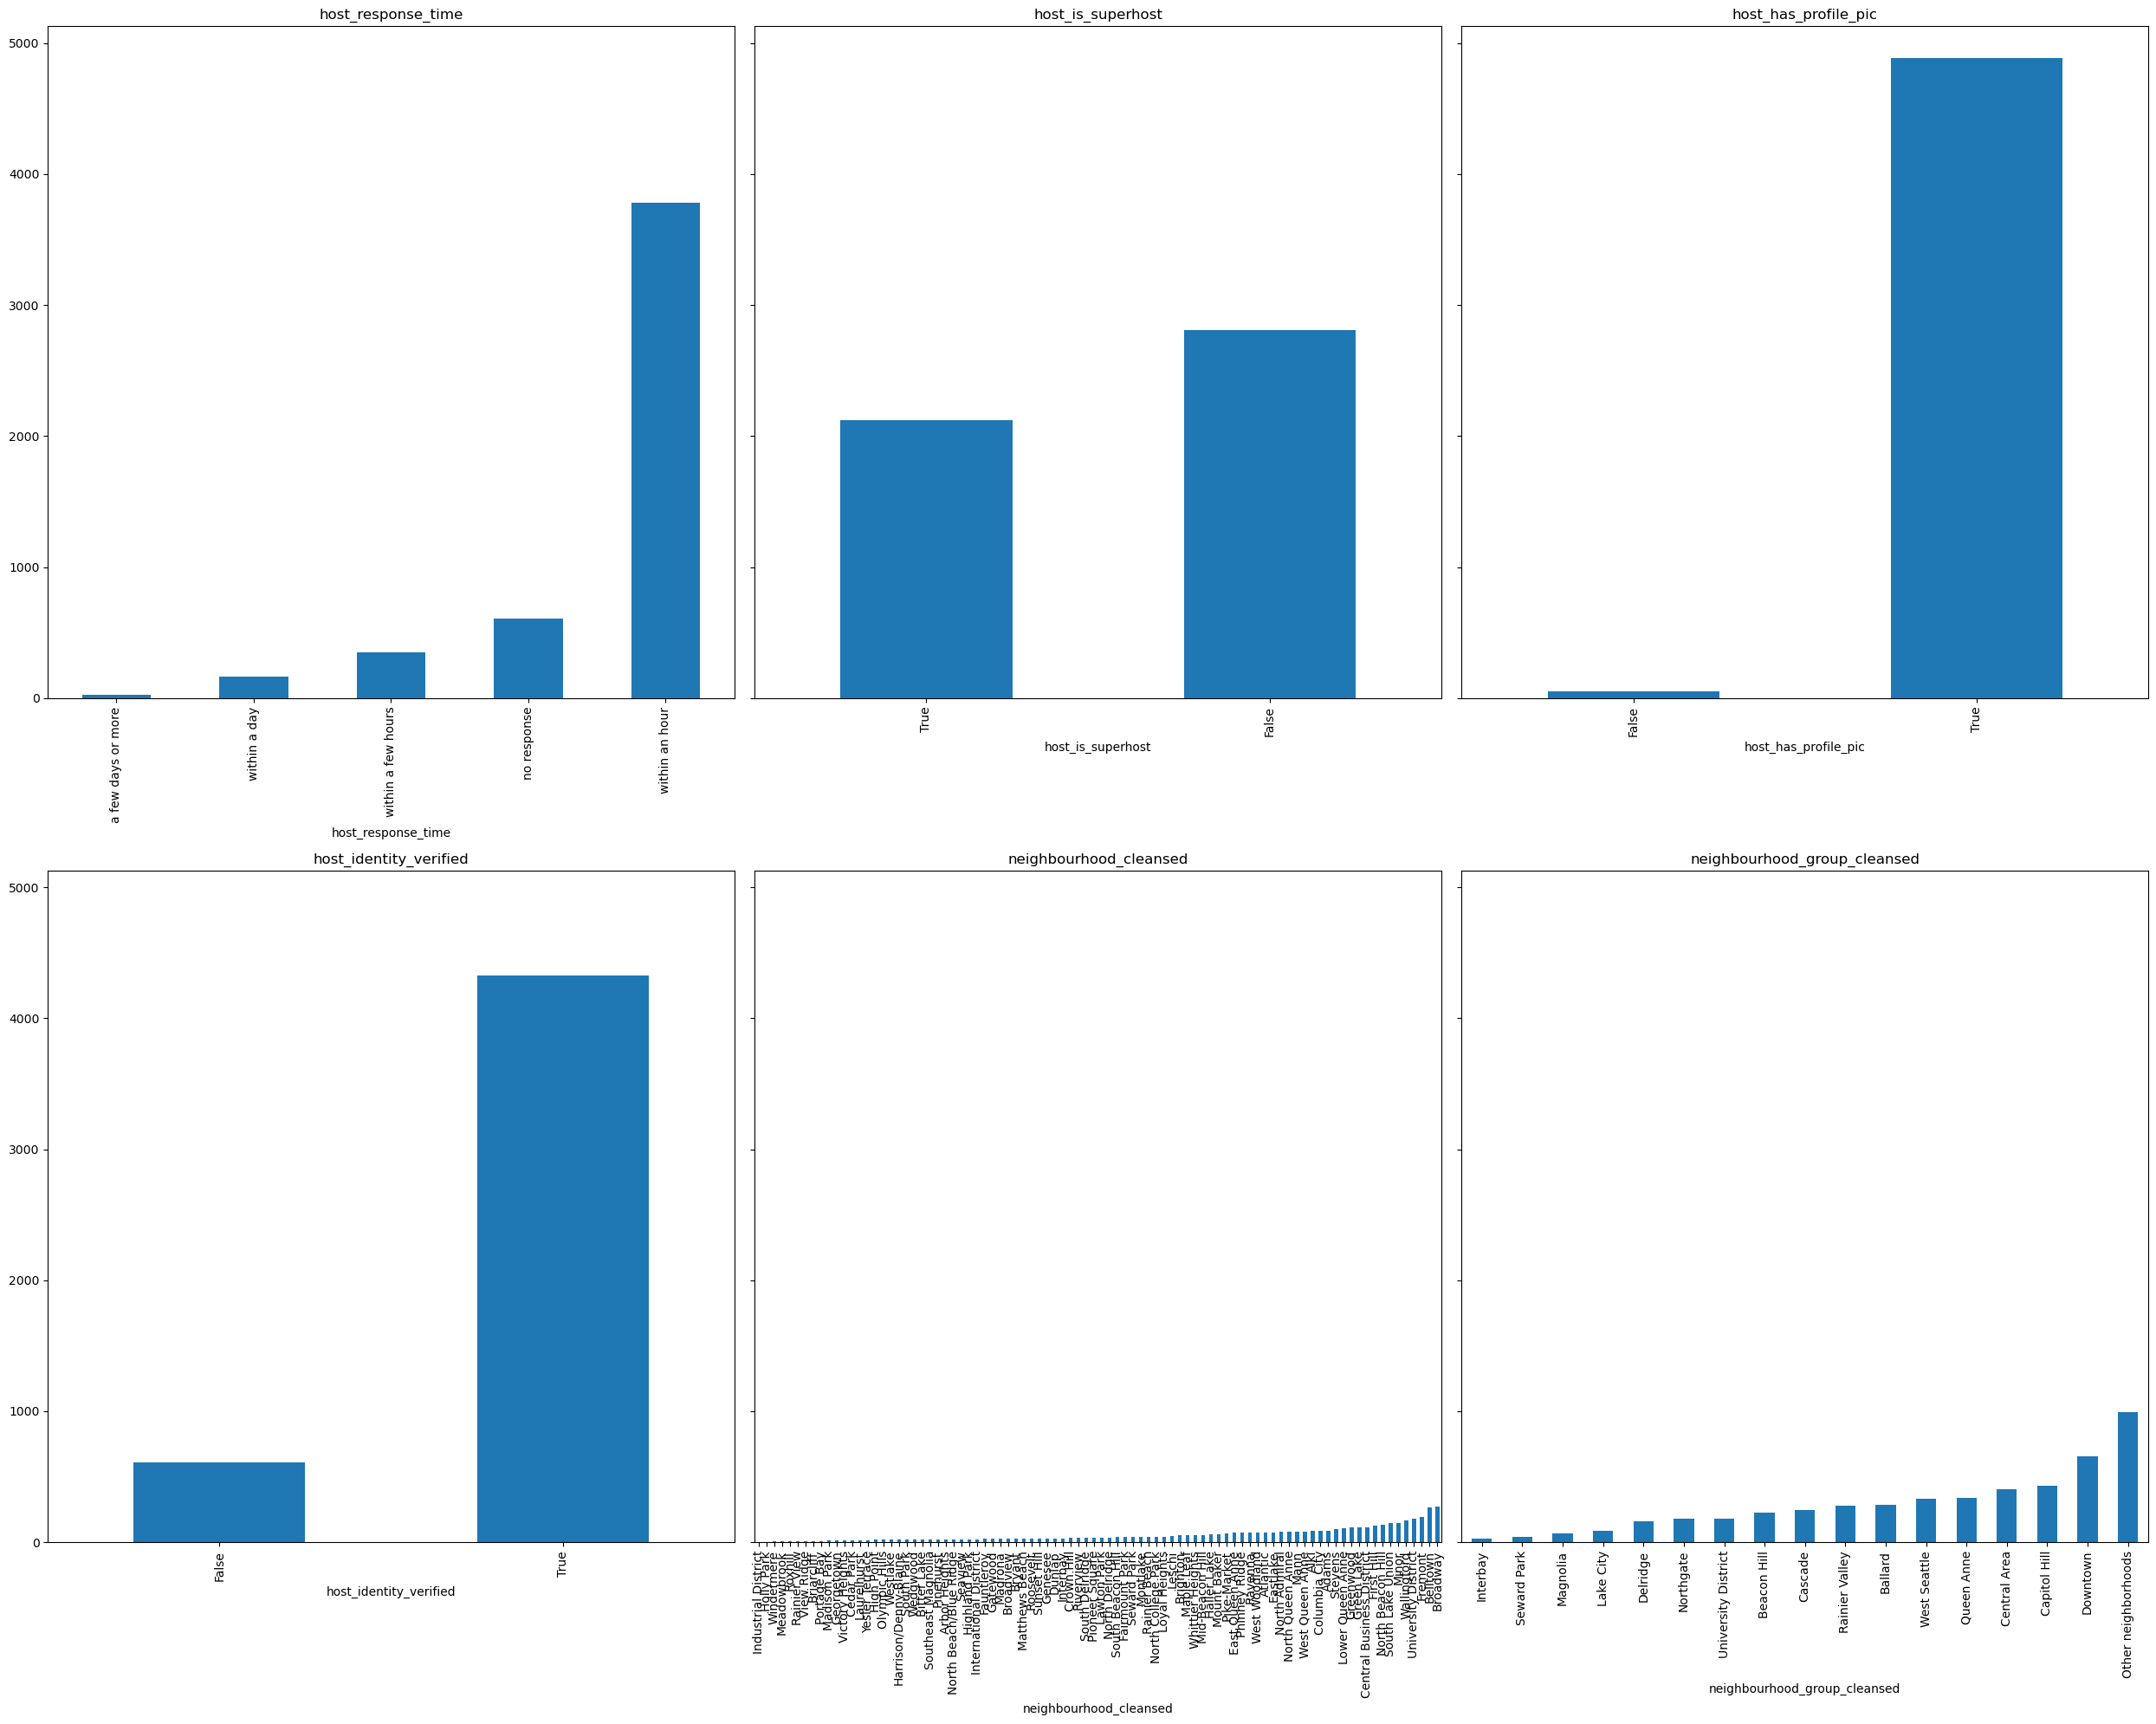

In [9]:
# distribution of each categorical column

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,20), sharey=True)

# Create bar plots
for col, ax in zip(cat_col, axes.flatten()):
    (listing_df.groupby(col)        # group values together by column of interest
         .count()['price']    # take the mean of the nightly_price for each group
         .sort_values()              # sort the groups in ascending order
         .plot
         .bar(ax=ax))                # create a bar graph on the ax
    
    ax.set_title(col)                # Make the title the name of the column
    
fig.tight_layout()

### 3.2 Distribution of each numeric column

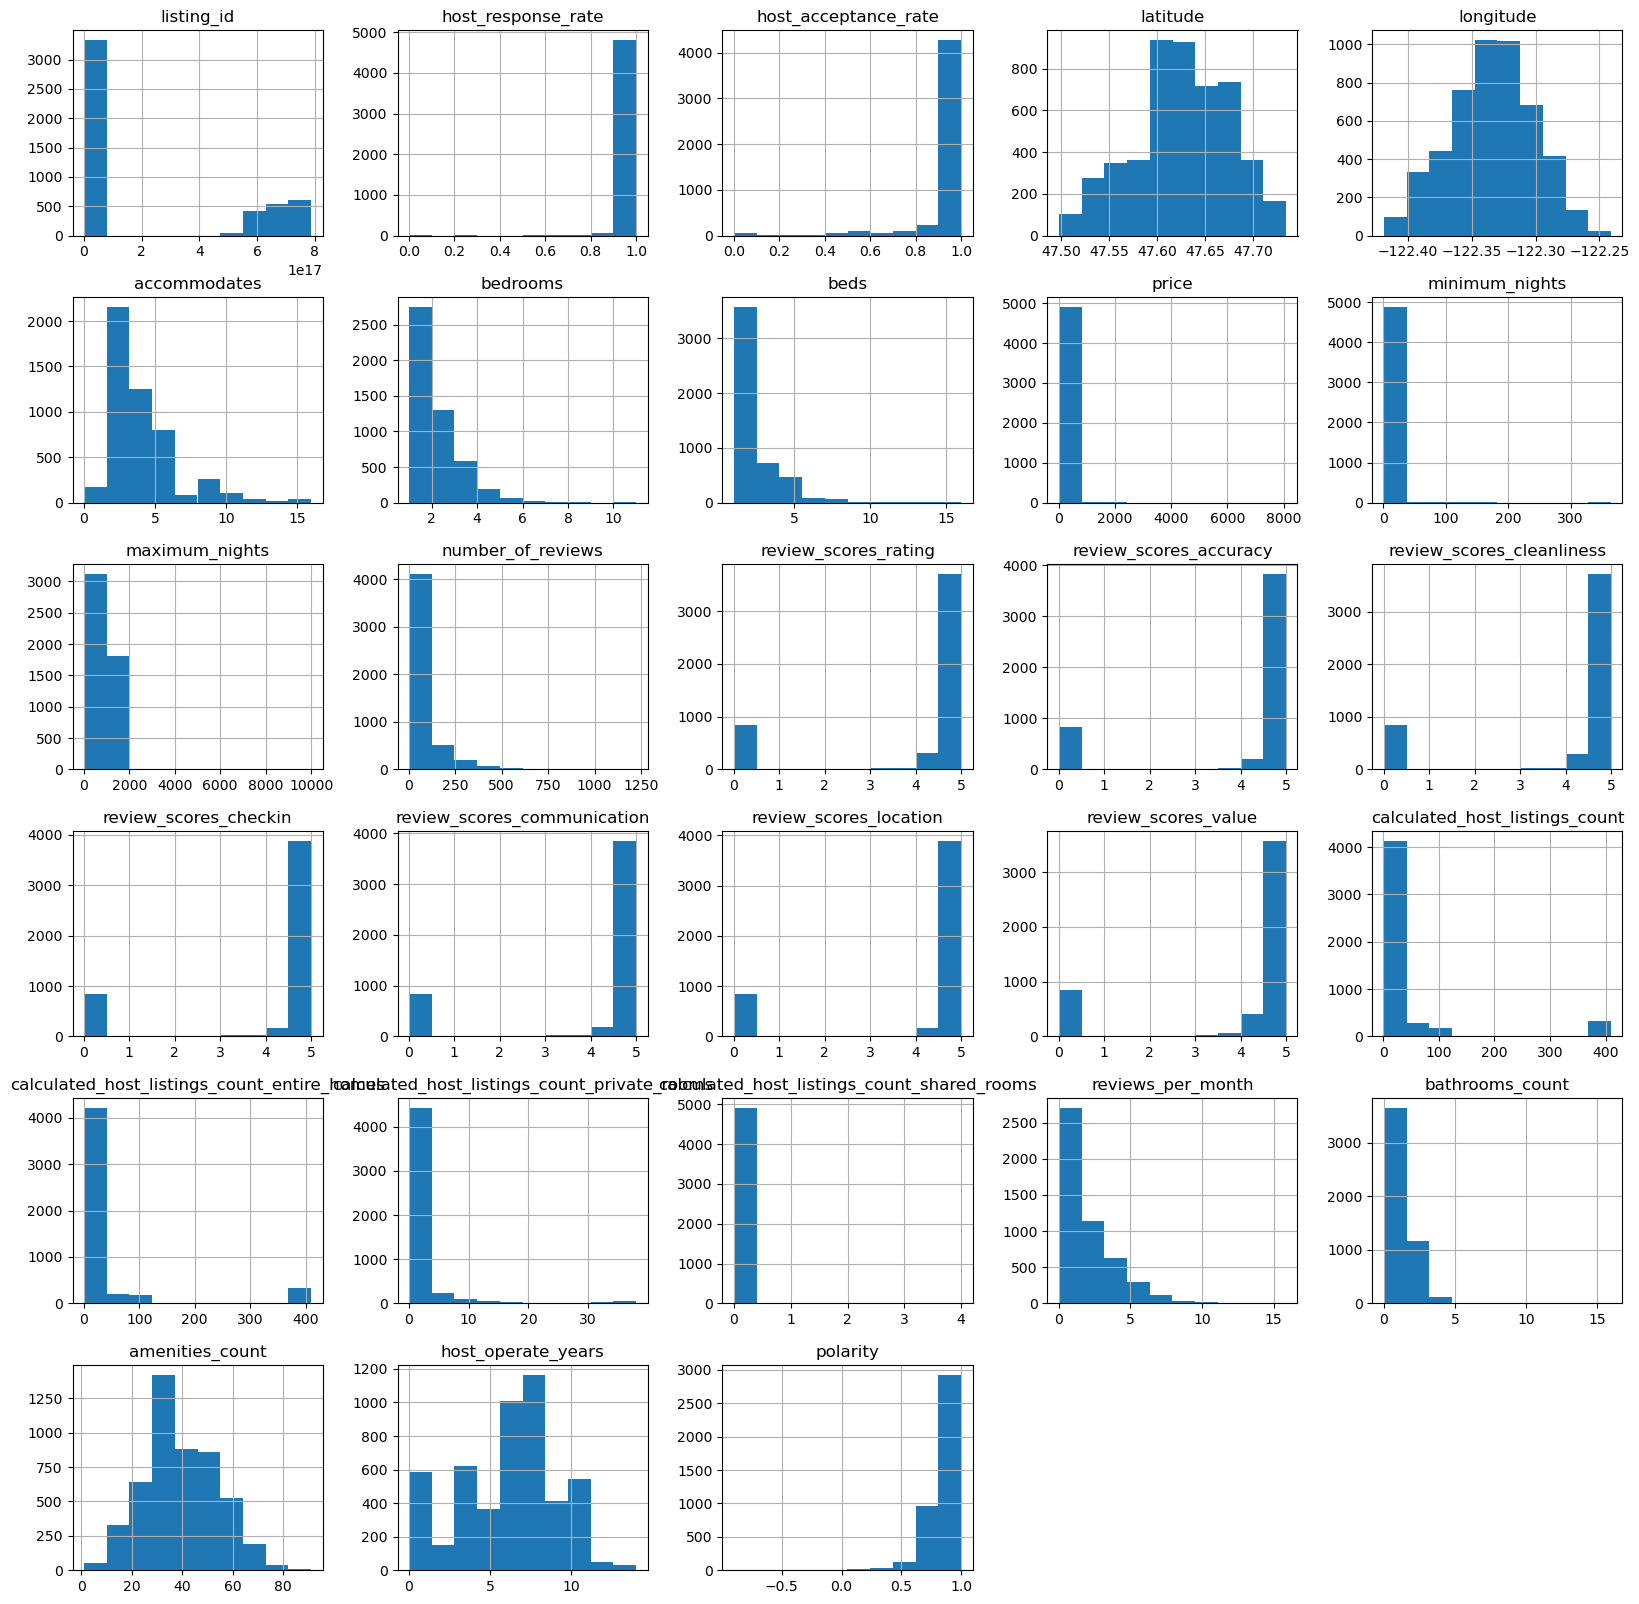

In [10]:
# distribution of each numeric column

listing_df.hist(figsize = (20,20))
plt.show()

### 3.3 Correlation Between Features

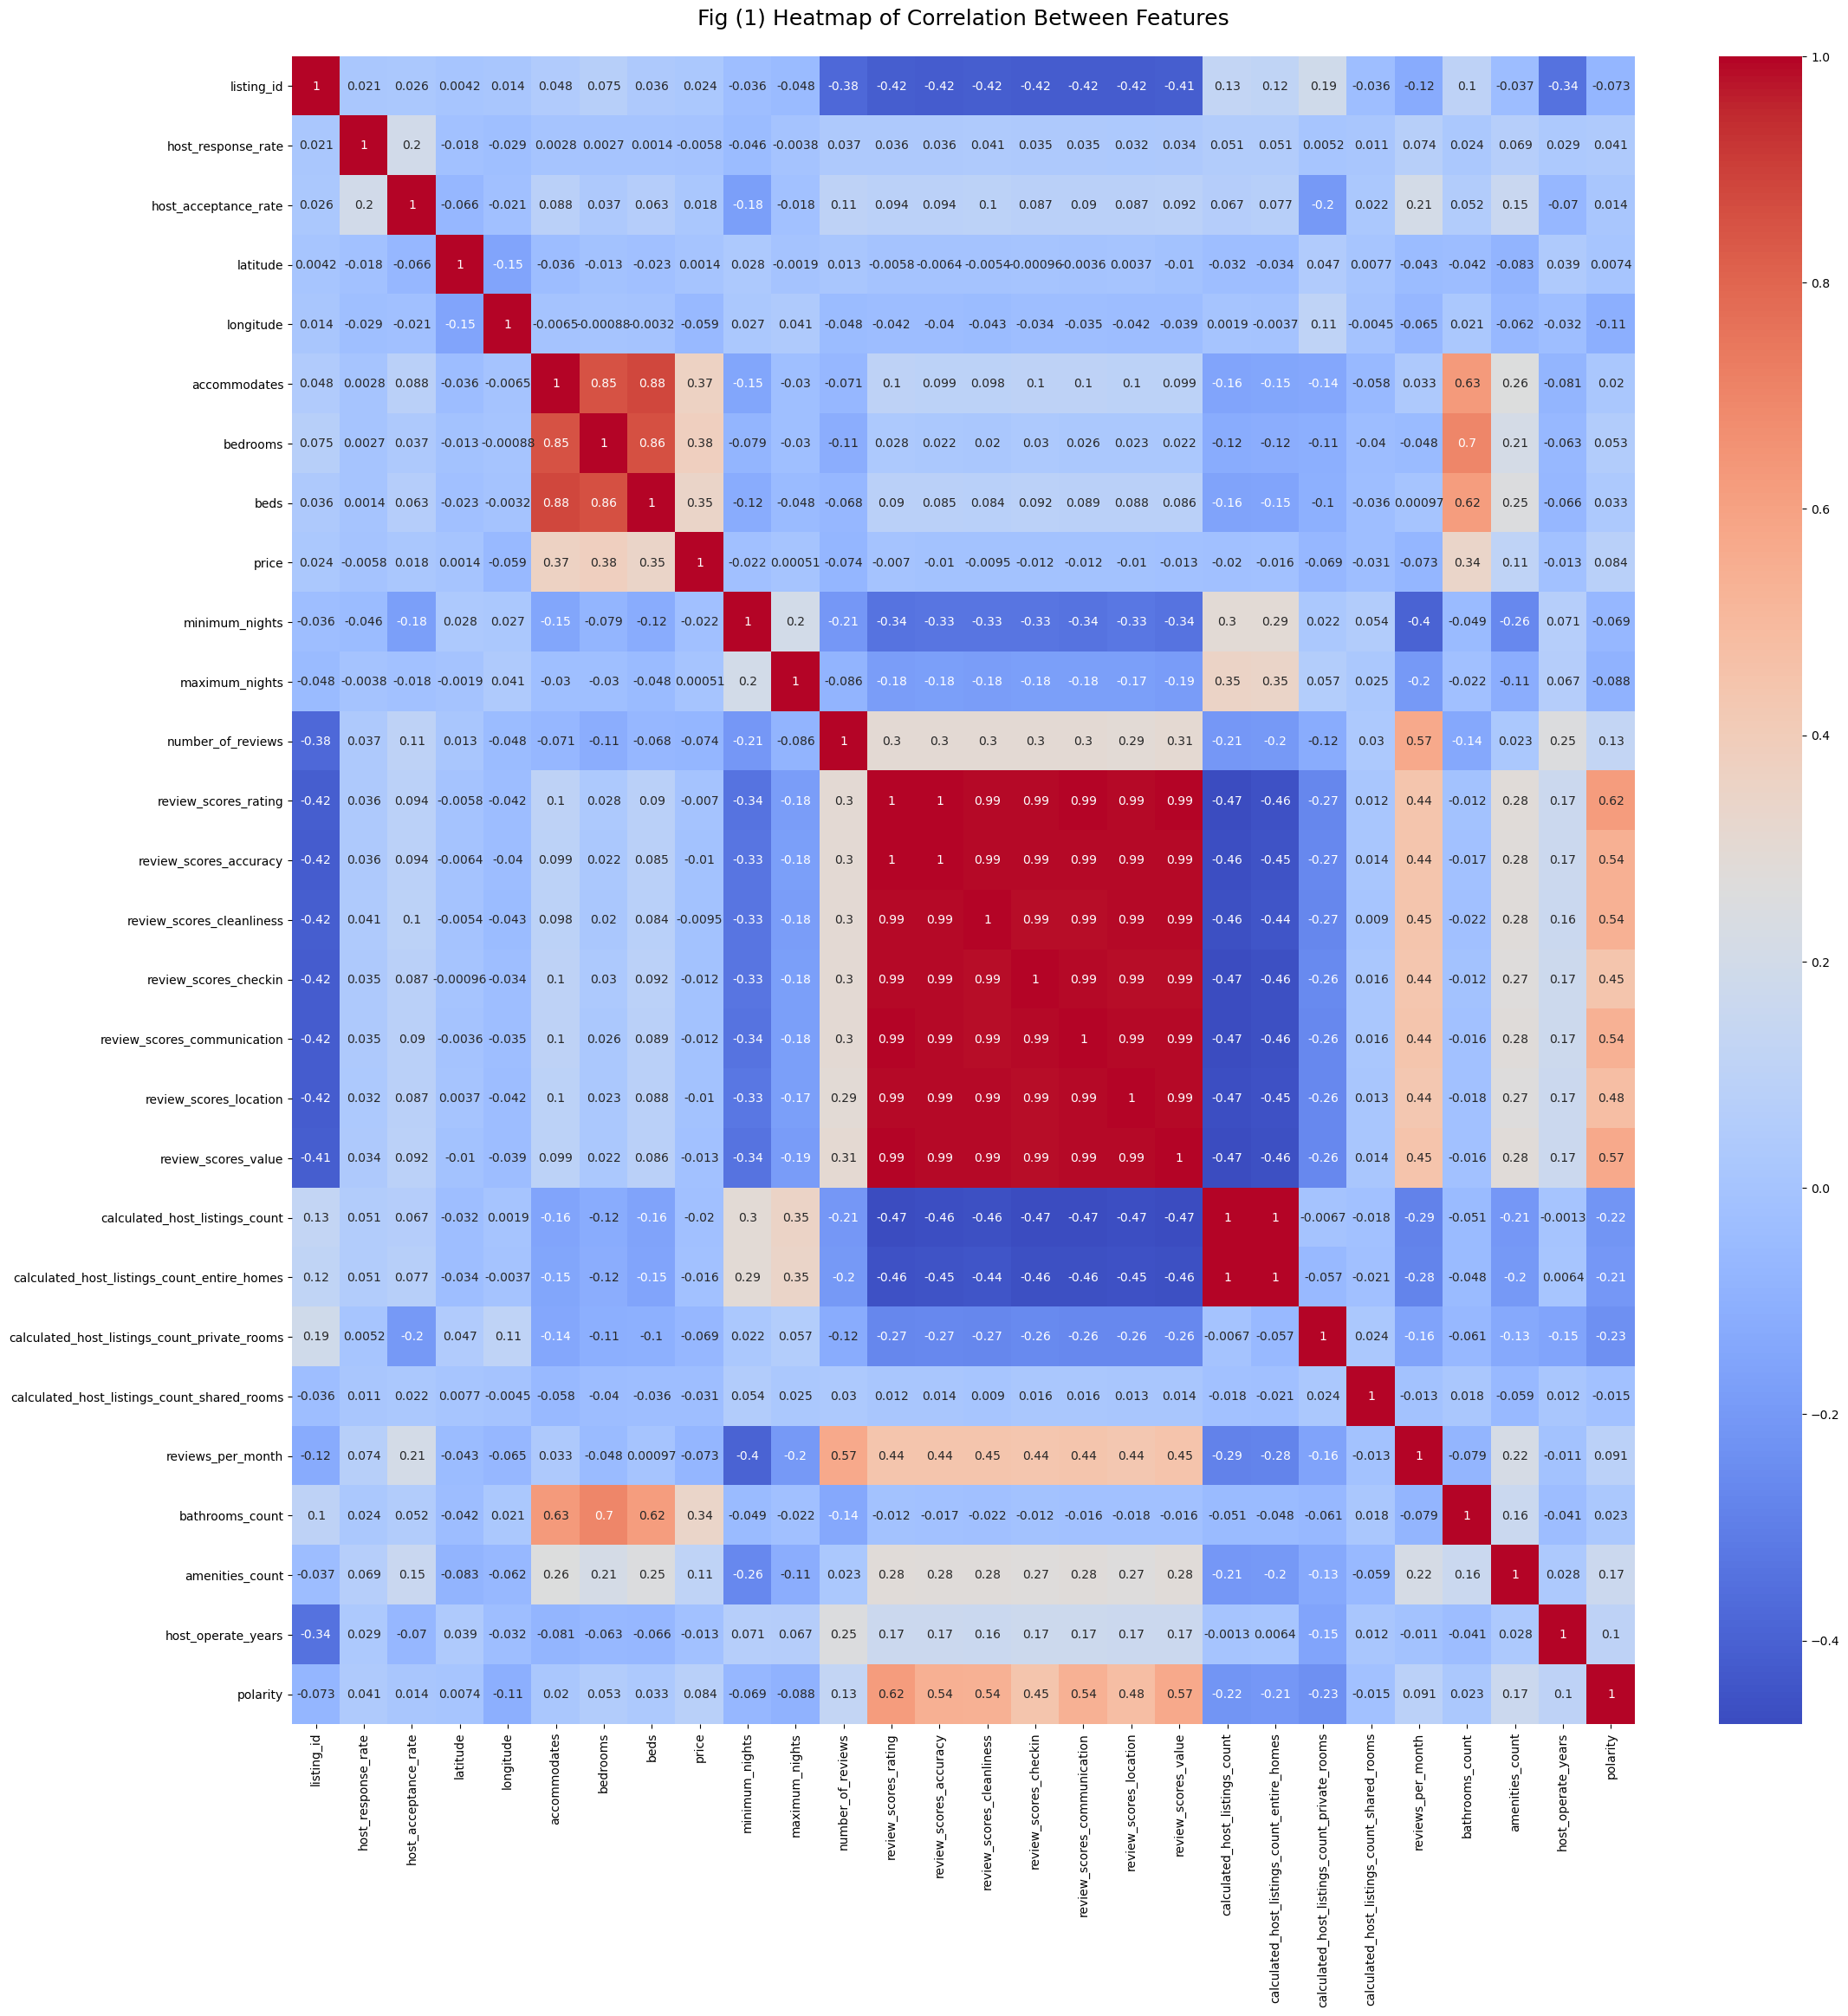

In [11]:
# set up figure size
fig, ax = plt.subplots(figsize=(25, 25))

# set up correlation matrix
corr = listing_df.corr()

sns.heatmap(corr, cmap = 'coolwarm', annot = True)

# Customize the plot appearance
ax.set_title("Fig (1) Heatmap of Correlation Between Features\n", fontsize = 18);

plt.savefig('heatmap.png')
plt.show()

### 4. Data transformation

### 4.1 Data preprocessing

In [12]:
# set listing id as the index
listing_df = listing_df.set_index('listing_id')

In [13]:
# convert to categorical dtype
for c in cat_col:
    listing_df[c]=listing_df[c].astype('category')

# define order of the ordinal features
response_time_list = ['within an hour',
                      'within a few hours', 
                      'within a day', 
                      'a few days or more', 
                      'no response']

In [14]:
# define nominal and ordinal features in the categorical columns
nom_cols = ['property_type','room_type','neighbourhood_cleansed','neighbourhood_group_cleansed'] + binary_cols

ordinal_cols = ['host_response_time']

### 4.2 Transformation pipeline

In [15]:
# define numeric transformation pipeline that scales the numbers
numeric_pipeline = Pipeline([('numnorm', StandardScaler())]) 

# define an ordinal transformation pipeline that ordinal encodes the cats
ordinal_pipeline = Pipeline([('ordinalenc', OrdinalEncoder(categories = [response_time_list]))])

# define a nominal transformation pipeline that OHE the cats
nominal_pipeline = Pipeline([('onehotenc', OneHotEncoder(categories= "auto", 
                                                         sparse = False, 
                                                         handle_unknown = 'ignore'))]) 

### 4.3 Column transformer

In [16]:
# construct column transformer for the selected columns with pipelines
ct = ColumnTransformer(transformers = [("nominalpipe", nominal_pipeline, nom_cols),
                                       ("ordinalpipe", ordinal_pipeline, ['host_response_time']),
                                       ("numericpipe", numeric_pipeline, 
                                        listing_df.select_dtypes(['int', 'float']).columns)])

In [17]:
# reorder the dataframe with nominal first, ordinal second, and remaining numeric last

listing_df = listing_df[ # nominal below this line
                    ['property_type','room_type','neighbourhood_cleansed','neighbourhood_group_cleansed', 
                     'host_is_superhost','host_has_profile_pic','host_identity_verified','has_availability',
                     'instant_bookable','has_license',
                     # ordinal below this line
                     'host_response_time',
                     # remaining numeric
                     'host_response_rate', 'host_acceptance_rate', 
                     'accommodates','bedrooms', 'beds', 
                     'bathrooms_count', 'amenities_count', 'price', 
                     'minimum_nights', 'maximum_nights',
                     'number_of_reviews', 'review_scores_rating',
                     'review_scores_accuracy', 'review_scores_cleanliness',
                     'review_scores_checkin', 'review_scores_communication',
                     'review_scores_location', 'review_scores_value',  
                     'calculated_host_listings_count',
                     'calculated_host_listings_count_entire_homes',
                     'calculated_host_listings_count_private_rooms',
                     'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
                     'host_operate_years', 'polarity','latitude','longitude']]

print(listing_df.shape)

(4933, 38)


### 4.4 Execute the transformation

In [18]:
# dataframe after data transformation
listing_trans = pd.DataFrame(ct.fit_transform(listing_df))
print(listing_trans.shape)

(4933, 197)


In [19]:
# get nominal values
nominal_features = list(nominal_pipeline.named_steps['onehotenc'].fit(listing_df[nom_cols]).get_feature_names_out())

# get ordinal values
ordinal_features = list(ordinal_cols)
ordinal_features

# get numeric values
numeric_features = ['host_response_rate', 'host_acceptance_rate', 'accommodates','bedrooms', 'beds', 
                     'bathrooms_count', 'amenities_count', 'price', 
                     'minimum_nights', 'maximum_nights',
                     'number_of_reviews', 'review_scores_rating',
                     'review_scores_accuracy', 'review_scores_cleanliness',
                     'review_scores_checkin', 'review_scores_communication',
                     'review_scores_location', 'review_scores_value',  
                     'calculated_host_listings_count',
                     'calculated_host_listings_count_entire_homes',
                     'calculated_host_listings_count_private_rooms',
                     'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
                     'host_operate_years', 'polarity','latitude','longitude']

In [20]:
# naming the columns of the transformed dataframe
listing_trans.columns = nominal_features + ordinal_features + numeric_features

# handling the missing/infinity values
listing_trans = listing_trans.fillna(0)

### 5. Clustering

### 5.1 UMAP embedding

In [21]:
# embedding = umap.UMAP(n_neighbors=500, min_dist= .9, metric='cosine').fit_transform(listing_trans)

In [22]:
# np.save('asset/embedding_plot.npy', embedding)

In [23]:
# sns.scatterplot(embedding[:,0], embedding[:,1], s = 5, alpha = 1)

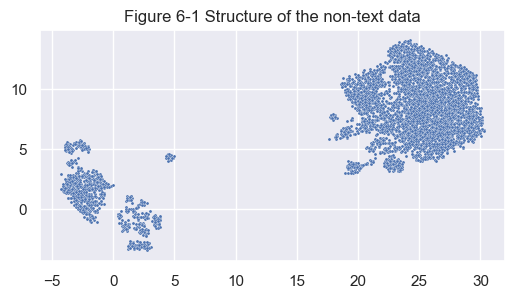

In [24]:
embedding = np.load('../data/data_cleaned/embedding_plot.npy')
sns.set_style("white")
sns.set(font_scale = 1)
# visualize the multi-dimension features
fig, ax = plt.subplots(figsize = (6,3))
sns.scatterplot(*embedding.T, s = 5, alpha = 1, ax = ax)
ax.set_title('Figure 6-1 Structure of the non-text data', fontsize = 12)


plt.show()

In [25]:
# p = sns.jointplot(*embedding.T, kind = 'hex', ratio=4, height = 8)
# p.fig.suptitle('Structure of the data', fontsize = 12, x = 0.4)
# plt.show()

### 5.2 KMeans

### 5.2.1 Function to find the clusters

In [39]:
def kmeans_cluster(df):

    kmeans_kwargs = {"init": "random",
                     "n_init": 10,
                     "max_iter": 300,
                     "random_state": 42}

    # A list holds the SSE values for each k
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
        kmeans.fit(df)
        sse.append(kmeans.inertia_)


    # A list holds the silhouette coefficients for each k
    silhouette_coefficients = []

    # Notice you start at 2 clusters for silhouette coefficient
    for k in range(2, 11):
        kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
        kmeans.fit(df)
        score = silhouette_score(df, kmeans.labels_)
        silhouette_coefficients.append(score)

    kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

    # we will use this result as the best number of clusters
    K = kl.elbow

    # plot the elbow plot and the Silhouette scores
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.set(font_scale = 1)
    ax[0].plot(range(1, 11), sse)
    ax[0].set_xticks(range(1, 11))
    ax[0].set_xlabel("Number of Clusters")
    ax[0].set_ylabel("SSE")
    ax[0].set_title('Figure 6-2 Inertia\n', fontsize = 12)
    ax[0].vlines(x=K, ymin=min(sse), ymax=max(sse), colors='red', linestyles='dotted')

    ax[1].plot(range(2, 11), silhouette_coefficients)
    ax[1].set_xticks(range(2, 11))
    ax[1].set_xlabel("Number of Clusters")
    ax[1].set_ylabel("Silhouette Coefficient")
    ax[1].set_title('Figure 6-3 Silhouette scores\n', fontsize = 12)
    ax[1].vlines(x=K, ymin=min(silhouette_coefficients), ymax=max(silhouette_coefficients), 
                 colors='red', linestyles='dotted')

    plt.show()


    # initiate kmeans
    kmeans = KMeans(n_clusters = K,
                    init='k-means++', 
                    verbose=0, 
                    n_init=10,
                    max_iter=300,
                    random_state=42,
                    algorithm='lloyd')

    # predict the clusters
    predict_cluster = kmeans.fit_predict(df)

    return predict_cluster

### 5.2.2 Dimensionality reduction with PCA

In [27]:
pca = prince.PCA(
     n_components=6,
     n_iter=10,
     rescale_with_mean=False,
     rescale_with_std=False,
     copy=True,
     check_input=True,
     engine='sklearn',
     random_state=42
 )
pca = pca.fit(listing_trans)

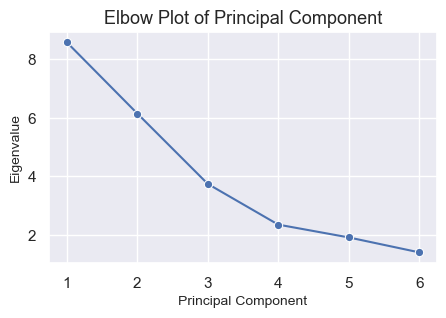

In [28]:
dset = pd.DataFrame()
dset['pca'] = range(1,7)
dset['eigenvalue'] = pd.DataFrame(pca.eigenvalues_)
plt.figure(figsize=(5,3))
sns.lineplot(x='pca', y='eigenvalue', marker="o", data=dset)
plt.ylabel('Eigenvalue', fontsize=10)
plt.xlabel('Principal Component', fontsize=10)
plt.title('Elbow Plot of Principal Component', fontsize=13)
plt.show()

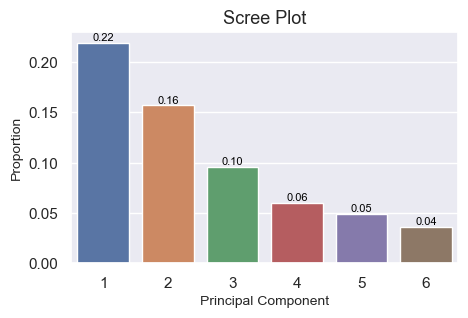

In [29]:
dset = pd.DataFrame()
dset['pca'] = range(1,7)
dset['vari'] = pd.DataFrame(pca.explained_inertia_)

plt.figure(figsize=(5, 3))
graph = sns.barplot(x='pca', y='vari', data=dset)
for p in graph.patches:
    graph.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                   ha='center', va='bottom',
                   color= 'black', fontsize=8)
plt.ylabel('Proportion', fontsize=10)
plt.xlabel('Principal Component', fontsize=10)
plt.title('Scree Plot', fontsize=13)
plt.show()

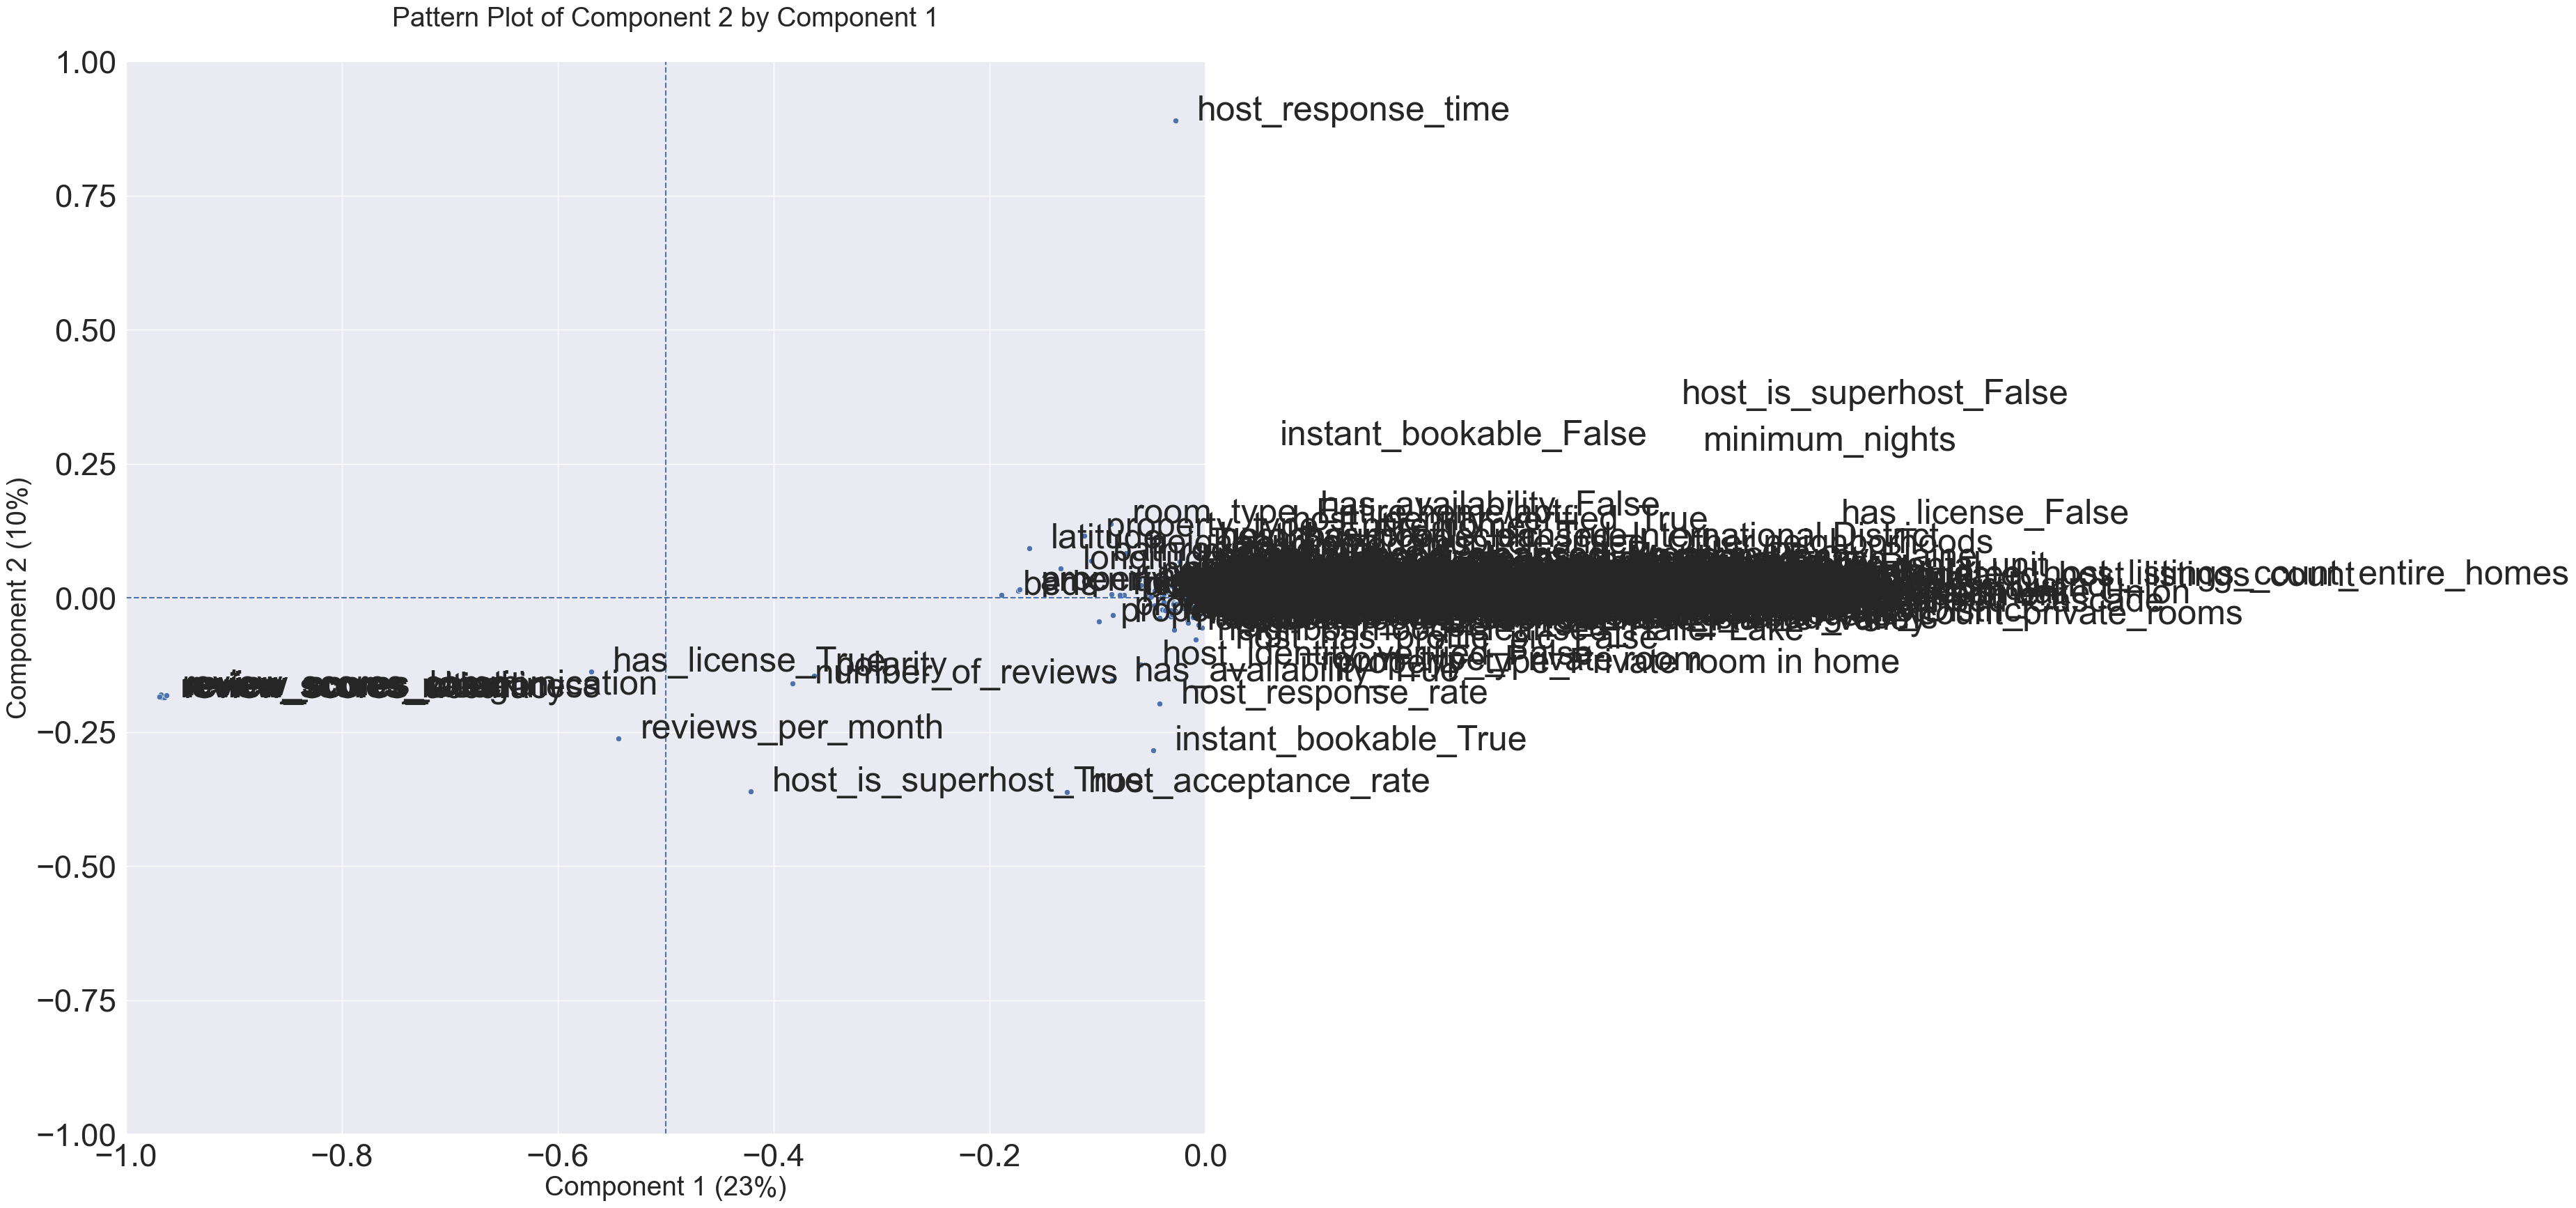

In [30]:
pca.column_correlations(listing_trans)

scatter = pd.DataFrame(pca.column_correlations(listing_trans)).reset_index()
plt.figure(figsize=(20,20))
sns.set(font_scale = 3)
ax = sns.scatterplot(x=0, y=1, data=scatter)
ax.set(ylim=(-1, 1), xlim=(-1,0))
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))
label_point(scatter[0], scatter[1], scatter['index'], plt.gca())  
plt.axvline(-0.5, ls='--')
plt.axhline(0, ls='--')
plt.title('Pattern Plot of Component 2 by Component 1\n', fontsize=28)
plt.xlabel('Component 1 (23%)', fontsize=28)
plt.ylabel('Component 2 (10%)', fontsize=28)
plt.show()

### 5.2.3 Find the best Kmeans cluster

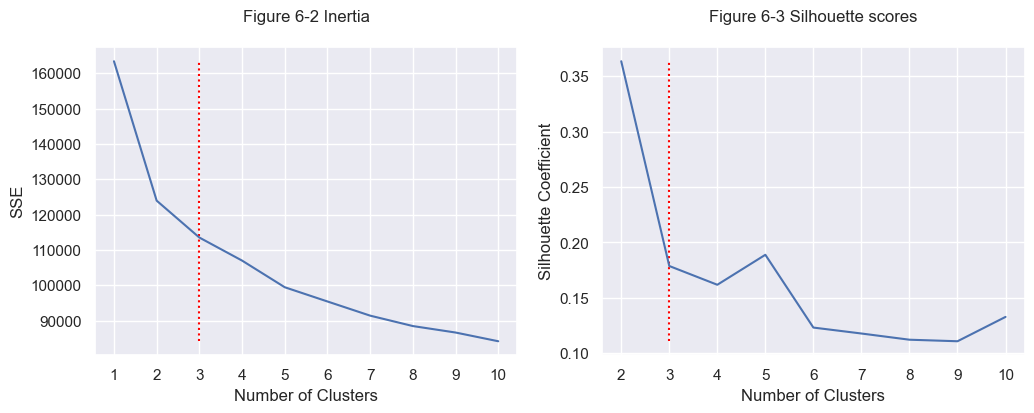

In [40]:
sns.set(font_scale = 1)
listing_df['cluster'] = list(kmeans_cluster(listing_trans))
listing_df['cluster'] = listing_df['cluster'].astype('category')

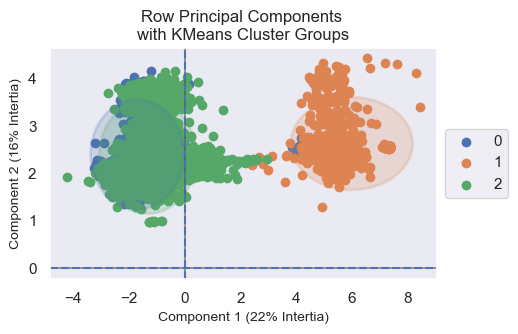

In [32]:
ax = pca.plot_row_coordinates(
     listing_trans,
     ax=None,
     figsize=(5, 3),
     x_component=0,
     y_component=1,
     labels=None,
     color_labels=listing_df['cluster'],
     ellipse_outline=True,
     ellipse_fill=True,
     show_points=True
 ).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Row Principal Components \nwith KMeans Cluster Groups', fontsize=12)
plt.xlabel('Component 1 (22% Intertia)',fontsize=10)
plt.ylabel('Component 2 (16% Intertia)', fontsize=10)
plt.axvline(0, ls='--') 
plt.axhline(0, ls='--') 
plt.show()

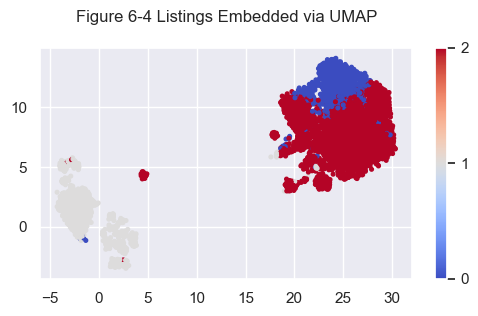

CPU times: user 206 ms, sys: 4.7 ms, total: 211 ms
Wall time: 209 ms


In [41]:
%%time
# plot clusters with UMAP 
sns.set(font_scale = 1)
fig, ax = plt.subplots(figsize = (6,3))

scatter_cpa = plt.scatter(*embedding.T, s = 7, alpha = 1, c = listing_df['cluster'], cmap = 'coolwarm')

# cluster label
cluster_label_cpa = list(listing_df['cluster'].unique())
labels = sorted(cluster_label_cpa) # cluster labels

cbar = plt.colorbar(scatter_cpa) 
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(labels)
plt.title('Figure 6-4 Listings Embedded via UMAP\n', fontsize=12);

plt.show()

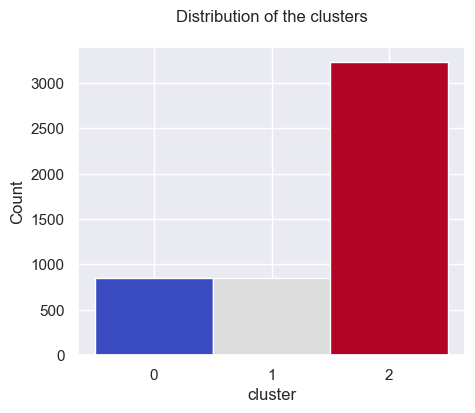

CPU times: user 188 ms, sys: 14.9 ms, total: 203 ms
Wall time: 202 ms


In [34]:
%%time
# show the cluster distribution

# cluster label
cluster_label = list(listing_df['cluster'].unique())

# find the cluster color in UMAP map
cluster_color_cpa = mcp.gen_color(cmap="coolwarm",n=len(cluster_label))

# plot the clusters
fig, ax = plt.subplots(figsize=(5,4))

ax = sns.histplot(data = listing_df['cluster'].cat.as_ordered())
ax.set_xticks(list(np.arange(0,len(cluster_label_cpa))))
ax.set_title('Distribution of the clusters\n',fontsize=12)

# set bar colors
for i in range(len(cluster_color_cpa)):
    ax.patches[i].set_facecolor(cluster_color_cpa[i])


plt.show()

### 5.2.4 Principal components 

In [35]:
# %%time

# factor = FactorAnalysis(n_components=5, random_state=42).fit(listing_trans)

# plot = pd.DataFrame(factor.components_,columns=list(listing_trans.columns)).T

# size_yaxis = round(listing_trans.shape[1] * 0.3)
# fig, ax = plt.subplots(figsize=(10,size_yaxis))
# sns.heatmap(plot, annot=True, cmap="YlGnBu", ax=ax, linewidths=.3)

# plt.show()

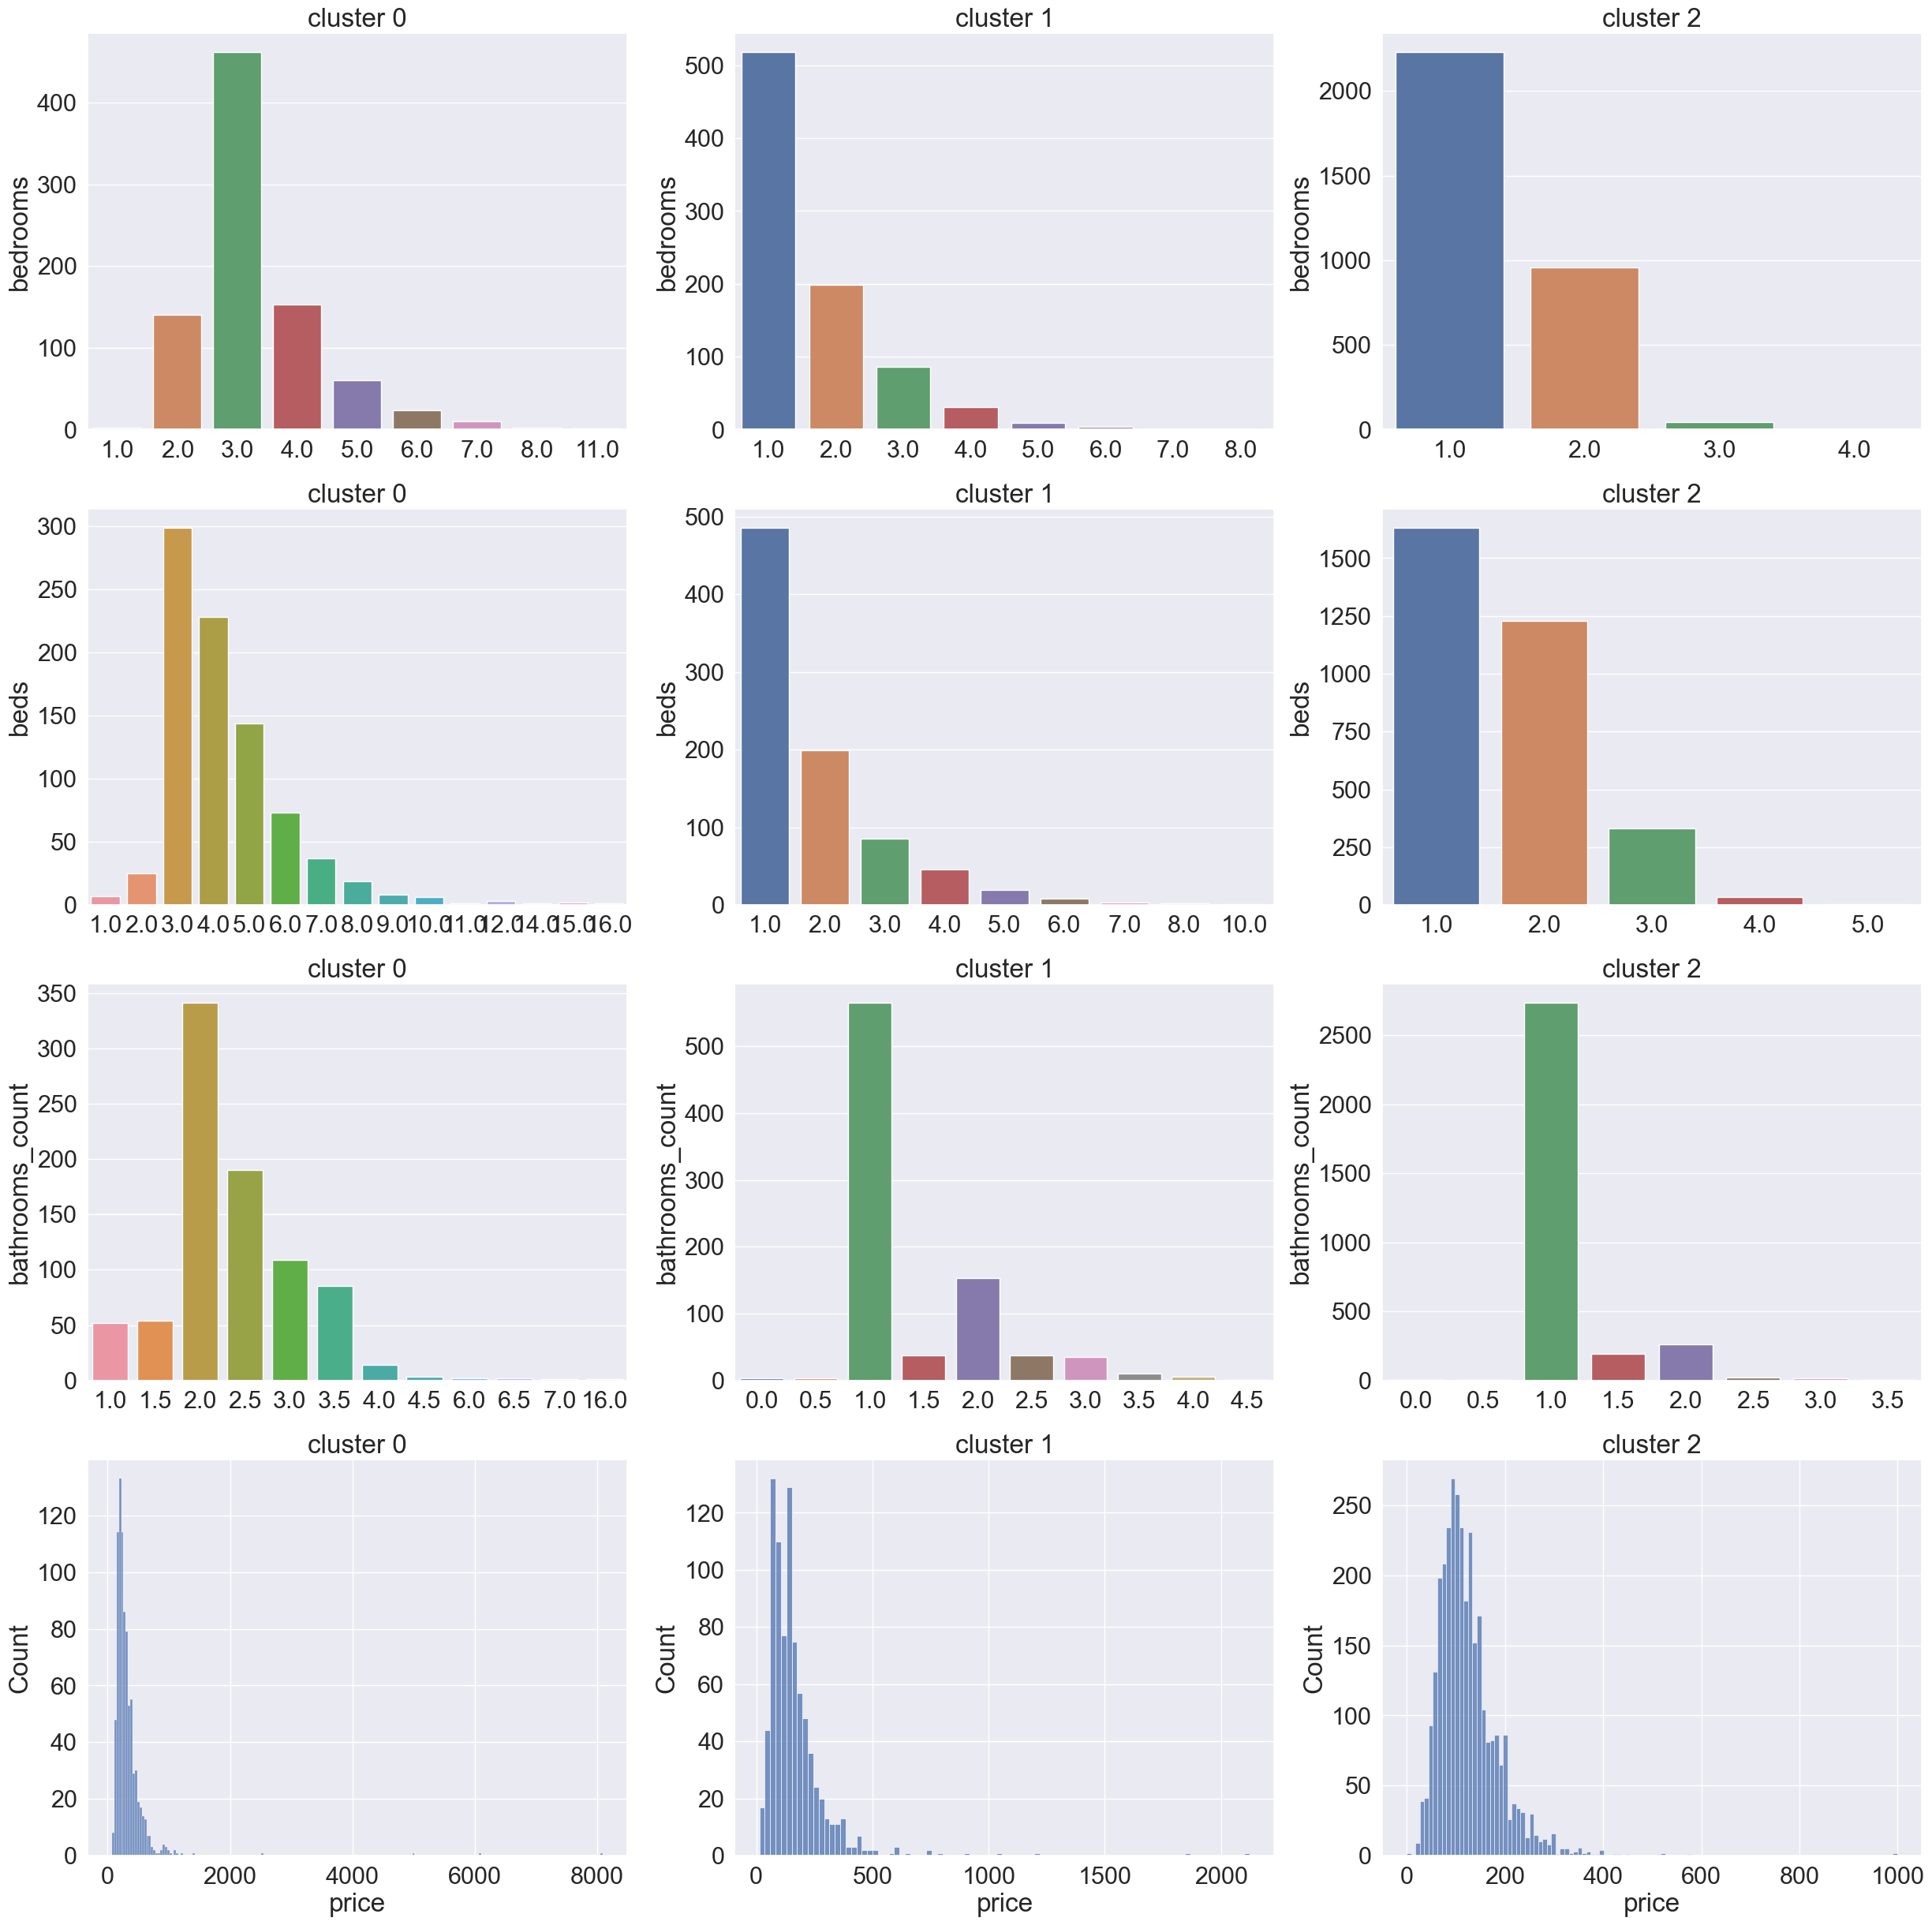

In [44]:
col = ['bedrooms', 'beds', 'bathrooms_count', 'price']
sns.set(font_scale = 2)
fig, axes = plt.subplots(len(col),len(cluster_label),figsize=(30,30))

df = listing_df.copy()

for c in range(len(col)):
    for i in range(len(cluster_label)):
        if i in df['cluster'].unique():
            if c in [0, 1, 2]:
                sns.barplot(data = df,
                        x=df.loc[df['cluster']==i][col[c]].value_counts().index,
                        y=df.loc[df['cluster']==i][col[c]].value_counts(),ax=axes[c,i]).set(title='cluster {}'.format(i))
                
            else:
                sns.histplot(df.loc[df['cluster']==i][col[c]],ax=axes[c,i]).set(title='cluster {}'.format(i))

# plt.savefig('distribution.png')


plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f2a50dc6-ff6a-45ff-9dbe-d7a35bd1e393' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>